In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
im_width = 256
im_height = 256

In [8]:
train_files = []
mask_files = glob('kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [9]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)

In [10]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [11]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

Enter the path to the TIFF image: 
  @media print {
    .ms-editor-squiggles-container {
      display:none !important;
    }
  }
  .ms-editor-squiggles-container {
    all: initial;
  }/home/mostafatarek/Videos/Brain Tumor Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif
1/1 [==============================] - 1s 761ms/step


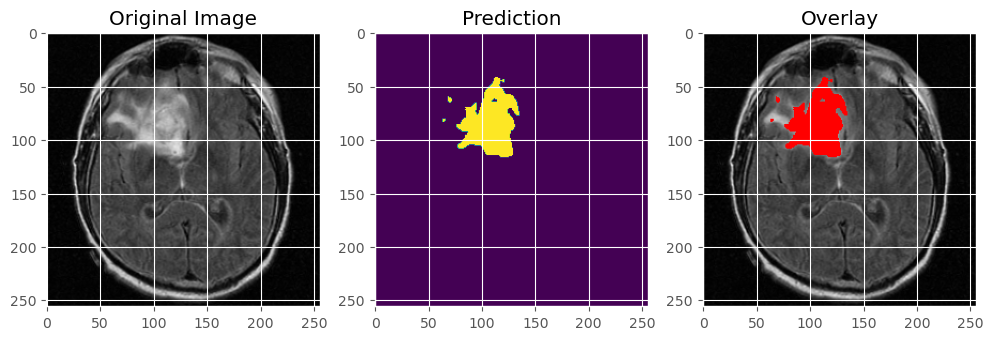

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

im_height, im_width = 256, 256

user_image_path = input("Enter the path to the TIFF image: ")

img = Image.open(user_image_path)

img_array = np.array(img)

slice_index = img_array.shape[2] // 2
img_slice = img_array[:, :, slice_index]

img_slice = cv2.resize(img_slice, (im_height, im_width))
img_slice = img_slice / np.max(img_slice)

img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)

img_slice_rgb = img_slice_rgb[np.newaxis, :, :, :]

pred = model.predict(img_slice_rgb)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img_slice_rgb))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(pred) > 0.5)
plt.title('Prediction')

plt.subplot(1, 3, 3)
overlay = np.squeeze(img_slice_rgb.copy())
overlay[np.squeeze(pred) > 0.5] = [1, 0, 0] 
plt.imshow(overlay)
plt.title('Overlay')

plt.show()


Enter the path to the TIFF image: 
  @media print {
    .ms-editor-squiggles-container {
      display:none !important;
    }
  }
  .ms-editor-squiggles-container {
    all: initial;
  }/home/mostafatarek/Videos/Brain Tumor Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif
1/1 [==============================] - 1s 738ms/step


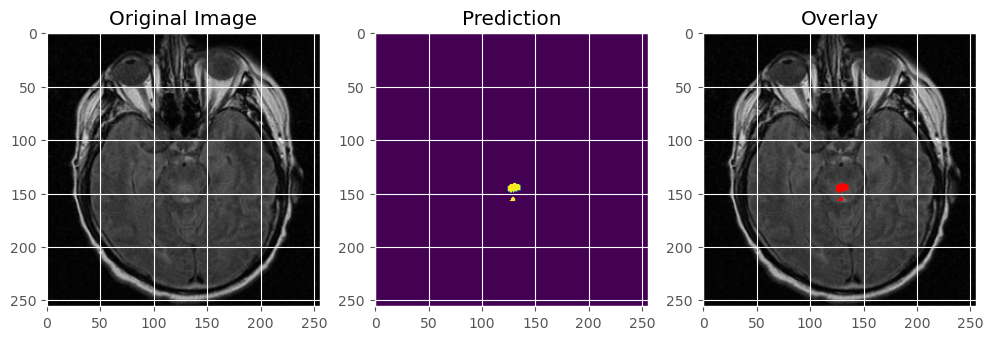

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

im_height, im_width = 256, 256

user_image_path = input("Enter the path to the TIFF image: ")

img = Image.open(user_image_path)

img_array = np.array(img)

slice_index = img_array.shape[2] // 2  # Use the middle slice for simplicity
img_slice = img_array[:, :, slice_index]

img_slice = cv2.resize(img_slice, (im_height, im_width))
img_slice = img_slice / np.max(img_slice)

img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)

# Add a batch dimension
img_slice_rgb = img_slice_rgb[np.newaxis, :, :, :]

pred = model.predict(img_slice_rgb)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img_slice_rgb))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(pred) > 0.5)
plt.title('Prediction')

plt.subplot(1, 3, 3)
overlay = np.squeeze(img_slice_rgb.copy())
overlay[np.squeeze(pred) > 0.5] = [1, 0, 0] 
plt.imshow(overlay)
plt.title('Overlay')

plt.show()
